# Plan
1. read data, split to labels and data, reshape data for Convulotional networks
2. explore data, view all categories
3. make dense model (model_1 in preivous notebook)
4. convulotional model (model_2 current notebook)
5. pretrained network ResNet50
6. Transfer learning with ResNet50


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import preprocessing 
from tensorflow.keras import backend as K
from skimage.transform import resize
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions,preprocess_input
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers


# Read Data

In [5]:
from tensorflow.keras.datasets import fashion_mnist
(xtrain,ytrain),(xtest,ytest) =fashion_mnist.load_data()
y_test_copy=ytest
#reshape
xtrain= xtrain.reshape((60000, 28, 28,1))
xtest= xtest.reshape((10000, 28, 28,1))


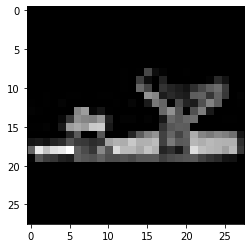

In [5]:
plt.imshow(xtrain[59999],cmap='gray')

In [6]:
# convert to RGB because ResNet input is RGB function
def img_set_to_rgb(data):
   img=[]
   #img=np.empty(data.shape)
   for i in range (len(data)):
       img_gray=data[i,:,:,:]
       img_rgb =cv2.cvtColor(img_gray,cv2.COLOR_GRAY2RGB)
       img.append(img_rgb) 
       
   img = np.asarray(img)
   return img   

In [7]:
# convert to RGB because ResNet input
xtest=img_set_to_rgb(xtest)
xtrain=img_set_to_rgb(xtrain)
xtrain.shape,xtest.shape


((60000, 28, 28, 3), (10000, 28, 28, 3))

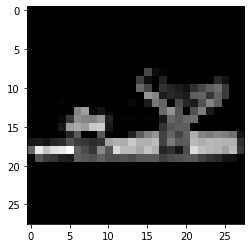

In [8]:
plt.imshow(xtrain[59999],cmap='gray')

<h5>Define labels </h5>


In [9]:
# dictionary of labels 
true_labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

# 4th model: Transfer learning with ResNet50
<h3> prepproceesing required </h3>

In [10]:
# convert to RGB because ResNet input is RGB function
def scale_img(data,width, height):
   img=[]
   dim = (width, height)
   for i in range (len(data)):
       img_var=data[i,:,:,:]
       img_resized =cv2.resize(img_var, dim, interpolation = cv2.INTER_AREA)
       img.append(img_resized) 
       
   img = np.asarray(img)
   return img   

In [11]:
#rescale image to the input data shape
X_train_image=scale_img(xtrain,224,224)
X_test_image=scale_img(xtest,224,224)

In [12]:
# preprocessing
X_train_image = preprocess_input(X_train_image)
X_test_image = preprocess_input(X_test_image)

In [13]:
X_train_image.shape, X_train_image.dtype

((60000, 224, 224, 3), dtype('float32'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


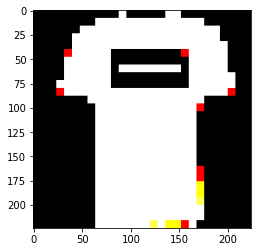

In [13]:
plt.imshow(X_train_image[1])  # come back to it

# Another way

In [38]:
classes=list(true_labels.values())

In [39]:
# imgae data generator and th efunctions to be applied to it
data_gen = preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

In [50]:
X_train_image.shape

(60000, 224, 224, 3)

In [ ]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow(X_train_image,y_train, subset='training', batch_size=30)

In [ ]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

# Transfer learning model

In [16]:
y_test = to_categorical(ytest)
y_train = to_categorical(ytrain)

In [17]:
K.clear_session()
model_4 = Sequential()
model_4.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet'))
model_4.add(Dense(10, activation = 'softmax'))
model_4.layers[0].trainable = False
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


# Compile and fit

In [18]:
model_4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])              

# observe the validation loss and stop when it does not improve after 3 iterations
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)
model_2_training = model_4.fit(X_train_image, y_train, epochs=40, batch_size = 50, validation_split=0.3, callbacks=[early_stopping_monitor], verbose=1)


Epoch 1/40
840/840 [==============================] - 3155s 4s/step - loss: 0.4676 - accuracy: 0.8373 - val_loss: 0.3558 - val_accuracy: 0.8738
Epoch 2/40
840/840 [==============================] - 3309s 4s/step - loss: 0.3307 - accuracy: 0.8821 - val_loss: 0.3127 - val_accuracy: 0.8891
Epoch 3/40
840/840 [==============================] - 4073s 5s/step - loss: 0.2939 - accuracy: 0.8943 - val_loss: 0.2973 - val_accuracy: 0.8934
Epoch 4/40
840/840 [==============================] - 9580s 11s/step - loss: 0.2716 - accuracy: 0.9029 - val_loss: 0.3155 - val_accuracy: 0.8865
Epoch 5/40
840/840 [==============================] - 9672s 12s/step - loss: 0.2603 - accuracy: 0.9060 - val_loss: 0.3029 - val_accuracy: 0.8929
Epoch 6/40
840/840 [==============================] - 8915s 11s/step - loss: 0.2487 - accuracy: 0.9093 - val_loss: 0.2753 - val_accuracy: 0.9027
Epoch 7/40
840/840 [==============================] - 3430s 4s/step - loss: 0.2350 - accuracy: 0.9165 - val_loss: 0.2895 - val_accura

In [19]:
# save model
model_4.save('models/transfer_learning_ResNet50.h5')

In [31]:
# predications
pred = model_4.predict(X_test_image)

# Test

In [26]:
t=X_test_image[1]
t = np.expand_dims(t, axis=0)
t.shape

(1, 224, 224, 3)

In [27]:
pred = model_4.predict(t)

In [29]:
true_labels[np.argmax(pred)]

'Pullover'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]

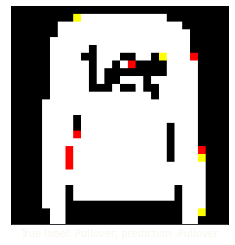

In [30]:
test=plt.imshow(X_test_image[1],cmap='gray')
plt.xlabel('True label: ' +str(true_labels[ytest[1]])+ '; prediction :'+ str(true_labels[np.argmax(pred)]), color='#F9F6EE')
ax = plt.gca()
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

Text(0, 0.5, 'accuracy')

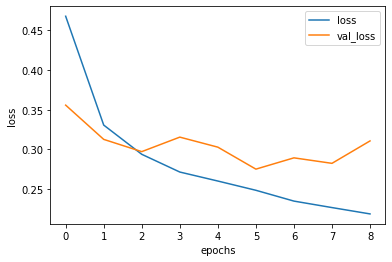

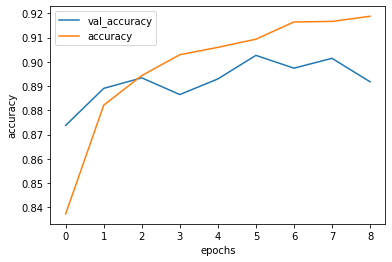

In [32]:
model_2_training.history.keys()
pd.DataFrame(model_2_training.history)[['loss', 'val_loss']].plot()
plt.xlabel('epochs')
plt.ylabel('loss')

#
pd.DataFrame(model_2_training.history)[['val_accuracy', 'accuracy']].plot()
plt.xlabel('epochs')
plt.ylabel('accuracy')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'T-shirt/top'),
  Text(1, 0, 'Trouser'),
  Text(2, 0, 'Pullover'),
  Text(3, 0, 'Dress'),
  Text(4, 0, 'Coat'),
  Text(5, 0, 'Sandal'),
  Text(6, 0, 'Shirt'),
  Text(7, 0, 'Sneaker'),
  Text(8, 0, 'Bag'),
  Text(9, 0, 'Ankle Boot')])

<Figure size 720x720 with 0 Axes>

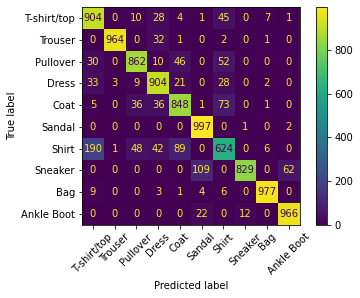

In [38]:
ax =plt.figure(figsize = (10,10))
cm = confusion_matrix(y_true=y_test_copy, y_pred=np.argmax(pred, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=true_labels.values())

disp.plot()                                 # change the size of the matrix
plt.xticks(rotation=45)